# Preconditioned SGD for high-resolution CryoEM reconstruction

Numerical experiments comparing stochastic gradient descent (SGD) with and and without a preconditioner, as well as our proposed way of estimating the preconditioner. 

In this notebook, interpolation in the forward model is performed using trilinear interpolation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, config
from tqdm import tqdm
import time
import mrcfile
import optax

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    precon_sgd,
    get_sgd_vol_ops,
    oasis,
    oasis_adaptive,
)
from simplecryoem.utils import rescale_larger_grid, mip_x, mip_y, mip_z
from simplecryoem.fsc import calc_fsc, average_shells, average_shells_2D
from simplecryoem.ctf import eval_ctf

2024-10-14 20:53:17.305804: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = '/ssd/Relion_10076_particles/'
star_file = 'my_particles_8.star'

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

load_data: number of partcles: 33026
load_data: data loaded, time:  33.34 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[10707  6049 19163  4747 28848 12283  6925  1608   809  3861]


In [5]:
out_dir =  "../../../simplecryoem_output/empiar_10076_8/"

nx_crop = 192 
N = 30000

idx = idx_full[:N]

In [6]:
save_figs = False
fig_dir =  "../../../simplecryoem_output/empiar_10076_8_figures/"

In [7]:
processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (33026, 320, 320)
pixel_size0.shape = (33026,)
angles0.shape = (33026, 3)
shifts0.shape = (33026, 2)
ctf_params0.shape = (33026, 9)
N0 = 33026
idx provided
N = 30000
Taking FFT of the images:
Batch 1/10  4.69 sec.
Batch 2/10  4.68 sec.
Batch 3/10  4.67 sec.
Batch 4/10  4.69 sec.
Batch 5/10  4.68 sec.
Batch 6/10  4.69 sec.
Batch 7/10  4.67 sec.
Batch 8/10  4.69 sec.
Batch 9/10  4.67 sec.
Batch 10/10  4.69 sec.
FFT done. Time:  51.91 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (30000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [8]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

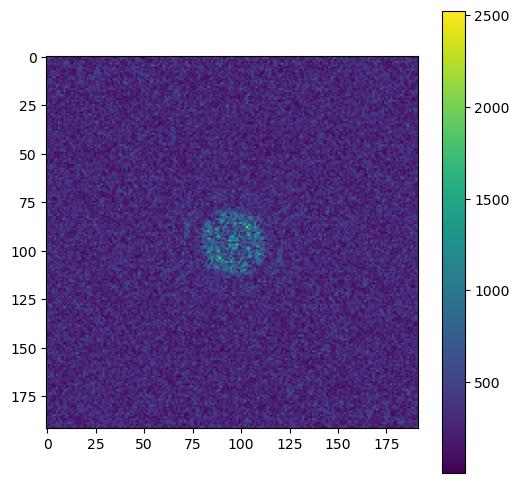

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [10]:
del imgs0

In [11]:
# Apply mask to images
apply_mask = True

if apply_mask:
    # mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

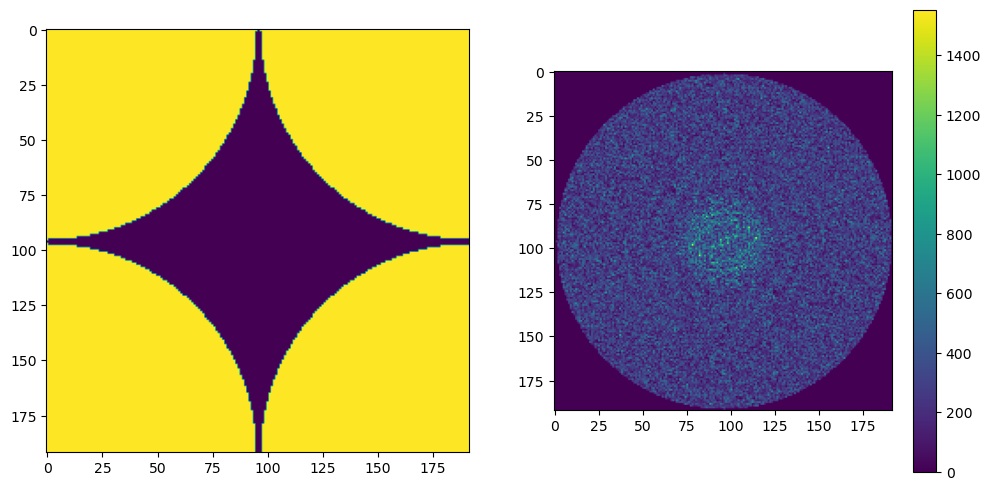

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop, nx_crop]))))
plt.colorbar()

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [13]:
jnp.save(f"{out_dir}/mask.npy", mask)

In [14]:
alpha = 1e-8 
interp_method = "tri" # "tri" or "nn"

slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

grad_func, loss_func, hvp_func, loss_px_func = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise
)

### Load a precomputed preconditioner

In [15]:
load_precon = True

if load_precon:
    n_epochs = 100 # 1000
    precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
    D0_loaded = jnp.load(precon_filename)

### Or compute a new preconditioner 

## TODO: run 1000 epochs here and then recompute the convergence plot

In [16]:
compute_precon = False

if compute_precon:
    # Exp avg convergence
    beta = 0.5
    DD0 = jnp.ones([nx, nx, nx])
    
    n_epochs = 10 #100
    batch_sz = 1000  # 100
    n_batch = N // batch_sz
    
    zD0z = np.zeros([nx, nx, nx])
    
    # zD0z = []
    
    key = random.PRNGKey(62)
    key, subkey = random.split(key)
    x0 = random.normal(subkey, [nx, nx, nx], dtype=jnp.complex128)
    
    count = 0
    D0err = []
    DDerr = []
    DD0 = jnp.ones([nx, nx, nx])
    
    for i in range(n_epochs):
        print(f"Epoch {i}")
        key, subkey = random.split(key)
        idx_batches = np.array_split(random.permutation(subkey, N), n_batch)
    
        for idx in tqdm(idx_batches):
            key, subkey = random.split(key)
    
            z = random.rademacher(subkey, [nx, nx, nx], dtype=x0.dtype)
            zD0z += z * hvp_func(x0, z, np.array(idx))
            count = count + 1
    
            Davg = zD0z / count
            DD1 = beta * DD0 + (1 - beta) * Davg
            DD0 = DD1
    
        # Computing convergence of the Hutchinson's estimator to the true preconditioner
        D0_current = zD0z / count
    
        if load_precon:
            err_current = D0_loaded - D0_current
            err_current = jnp.sum(jnp.real(jnp.conj(err_current) * err_current))
        
            D0err.append(err_current)
        
            dd_err_current = D0_loaded - DD1
            dd_err_current = jnp.sum(jnp.real(jnp.conj(dd_err_current) * dd_err_current))
        
            DDerr.append(dd_err_current)
    
    
    zD0z = np.array(zD0z)
    D0 = zD0z / (n_epochs * n_batch)
    
    plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0, :, :])))
    plt.colorbar()
    print(jnp.min(jnp.abs(D0)))
    print(jnp.max(jnp.abs(D0)))
    print(jnp.max(jnp.abs(D0)) / jnp.min(jnp.abs(D0)))

In [46]:
# Save the preconditioner
save_precon = True

if save_precon:
    precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
    jnp.save(precon_filename, D0)

In [47]:
print(f'max |D0| = {jnp.max(jnp.abs(D0))}')
print(f'min |D0| = {jnp.min(jnp.abs(D0))}')

max |D0| = 0.01882878923941523
min |D0| = 9.999999999999939e-09


In [48]:
D0_loaded_norm = jnp.sum(jnp.real(jnp.conj(D0_loaded) * D0_loaded))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


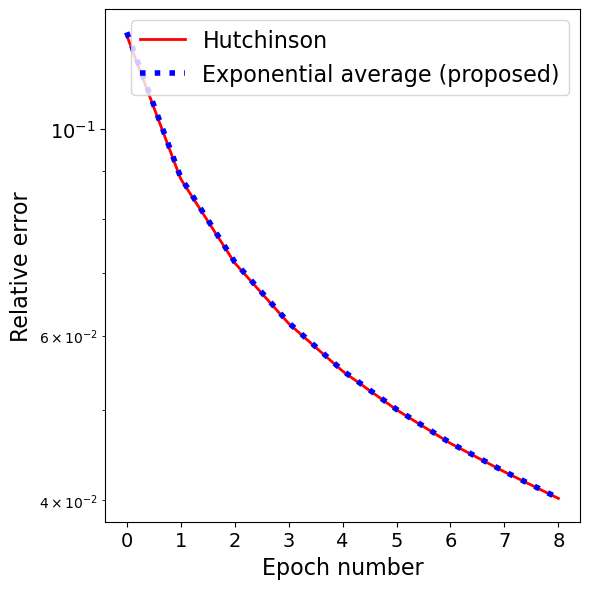

In [49]:
startidx = 0
plt.semilogy(
    jnp.sqrt(jnp.array(D0err[startidx:-1])) / jnp.sqrt(D0_loaded_norm),
    linewidth=2,
    color="r",
)
plt.semilogy(
    jnp.sqrt(jnp.array(DDerr[startidx:-1])) / jnp.sqrt(D0_loaded_norm),
    linewidth=4,
    linestyle="dotted",
    color="b",
)

# plt.title("$||D-diag(H)||_2 / ||H||_2$", fontsize=22)

plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.legend(["Hutchinson", "Exponential average (proposed)"], fontsize=16)

if save_figs:
    plt.savefig(f'{fig_dir}/Hutch_est_error.eps')

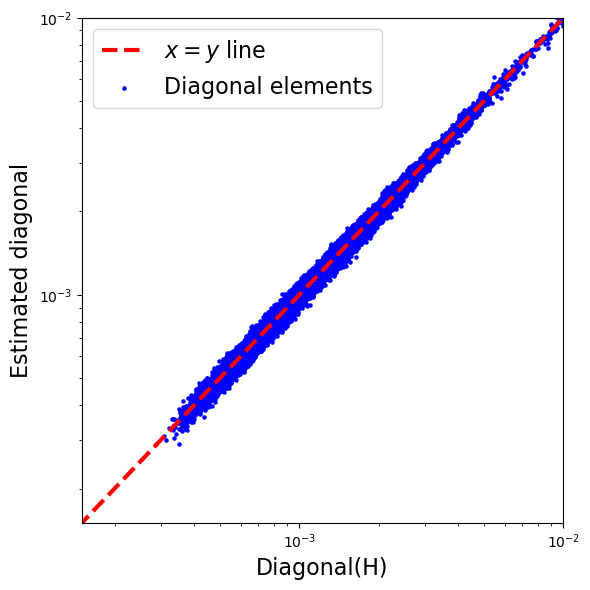

In [50]:
# When plotting the entries, only show a random subset,
# otherwise the eps image becomes huge.
idxs = random.permutation(key, nx**3)[:100000]

mind = jnp.min(D0_loaded)
maxd = jnp.max(D0_loaded)
xy = jnp.linspace(mind, maxd, 1000)

fig = plt.figure()
ax = plt.gca()

ax.plot(xy, xy, linewidth=3, linestyle="dashed", c="r")
ax.scatter(
    jnp.abs(D0_loaded).reshape(-1)[idxs],
    jnp.abs(DD1).reshape(-1)[idxs],
    s=5,
    c="b",
    marker="o",
)

ax.set_xscale("log")
ax.set_yscale("log")

axlims = [1.5e-4,1e-2]
plt.xlim(axlims)
plt.ylim(axlims)

plt.xlabel("Diagonal(H)", fontsize=16)
plt.ylabel("Estimated diagonal", fontsize=16)

plt.legend(["$x=y$ line", "Diagonal elements"], fontsize=16)
plt.tight_layout()

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

if save_figs:
    plt.savefig(f'{fig_dir}/Hutch_est_gt_vs_est.pdf')

### Inititial points

In [17]:
# Use a fixed seed and the same size (e.g. 320) every time we generate x01 and x02
# and only then crop to the intended size, to ensure that we always generate the same starting
# points no matter the dimensions.
key = random.PRNGKey(64)
key, subkey = random.split(key)

x0 = random.normal(subkey, [320, 320, 320], dtype=jnp.complex128)
x0 = x0[:nx, :nx, :nx]

key_alg = random.PRNGKey(101)
print(f"PRNGKey = {key_alg}")

PRNGKey = [  0 101]


### Common parameters for all runs

In [18]:
N_epochs = 10
batch_size = 1000
iter_display = 1

# Step size for the `sgd` function
eta_sgd = 1

# Initial step size for the `precon_sgd` function
eta_precon_sgd = 10

# Constant that determines the strength of the Armijo condition
c = 0.99

# Preconditioner
if load_precon:
    D0 = D0_loaded

# Weight used in the exponential average when estimating the preconditioner
beta = 0.9 * np.ones(x0.shape)

# Thershold for the preconditioner
# We take this to be the 1/(N points in the largest Fourier shell)
_, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
alpha = 1 / jnp.max(shell_pts)
print(alpha)

# So the thresholded preconditioner is:
D0hat = jnp.maximum(jnp.abs(D0), alpha)

# Directory to save all the iterates for further analysis
iterates_file_root = f"{out_dir}/iterates_{interp_method}/"

5.213981813631434e-06


## Comparison of algorithms

### 1. SGD: no preconditioning

In [53]:
t0 = time.time()

v_np, loss_np, grad_np, iterates_np, step_sizes_np = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 30/30 [00:30<00:00,  1.01s/it, eta=2.000e+00, grad=1.953e+01, 


  |Grad| = 2.393e+01
  Loss = 1.57253774e+09
  eta = 2.0
  alpha = 1e-10
Epoch 2/10 

100%|█| 30/30 [00:22<00:00,  1.36it/s, eta=4.000e+00, grad=1.539e+01, 


  |Grad| = 1.769e+01
  Loss = 1.56311428e+09
  eta = 4.0
  alpha = 1e-10
Epoch 3/10 

100%|█| 30/30 [00:21<00:00,  1.39it/s, eta=4.000e+00, grad=1.147e+01, 


  |Grad| = 1.305e+01
  Loss = 1.55929703e+09
  eta = 4.0
  alpha = 1e-10
Epoch 4/10 

100%|█| 30/30 [00:21<00:00,  1.39it/s, eta=4.000e+00, grad=8.394e+00, 


  |Grad| = 9.940e+00
  Loss = 1.55760269e+09
  eta = 4.0
  alpha = 1e-10
Epoch 5/10 

100%|█| 30/30 [00:21<00:00,  1.38it/s, eta=4.000e+00, grad=7.483e+00, 


  |Grad| = 7.796e+00
  Loss = 1.55662352e+09
  eta = 4.0
  alpha = 1e-10
Epoch 6/10 

100%|█| 30/30 [00:21<00:00,  1.37it/s, eta=4.000e+00, grad=6.548e+00, 


  |Grad| = 6.779e+00
  Loss = 1.55598413e+09
  eta = 4.0
  alpha = 1e-10
Epoch 7/10 

100%|█| 30/30 [00:21<00:00,  1.37it/s, eta=4.000e+00, grad=7.288e+00, 


  |Grad| = 6.736e+00
  Loss = 1.55553521e+09
  eta = 4.0
  alpha = 1e-10
Epoch 8/10 

100%|█| 30/30 [00:21<00:00,  1.37it/s, eta=4.000e+00, grad=7.527e+00, 


  |Grad| = 6.721e+00
  Loss = 1.55520275e+09
  eta = 4.0
  alpha = 1e-10
Epoch 9/10 

100%|█| 30/30 [00:21<00:00,  1.37it/s, eta=4.000e+00, grad=7.095e+00, 


  |Grad| = 6.700e+00
  Loss = 1.55494582e+09
  eta = 4.0
  alpha = 1e-10
Epoch 10/10 

100%|█| 30/30 [00:21<00:00,  1.37it/s, eta=4.000e+00, grad=6.886e+00, 


  |Grad| = 6.760e+00
  Loss = 1.55474283e+09
  eta = 4.0
  alpha = 1e-10
Total time:  257.30 seconds


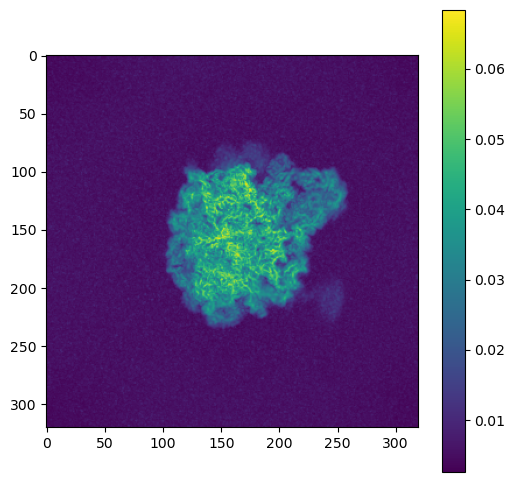

In [54]:
v_np_l, _ = rescale_larger_grid(v_np, x_grid, nx0)
vr_np = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np_l)))

mip_z(vr_np)
plt.colorbar()

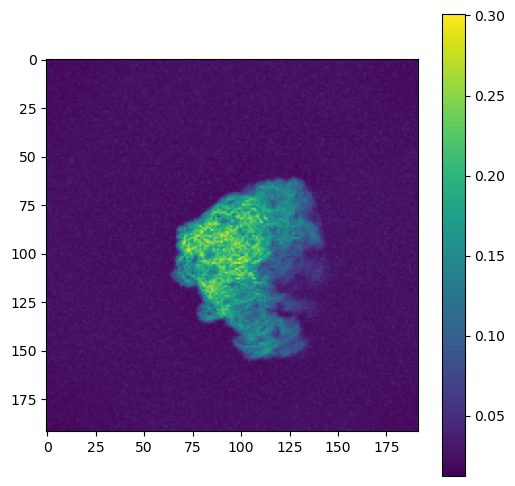

In [55]:
vr_np = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np)))

mip_x(vr_np)
plt.colorbar()

In [56]:
with mrcfile.new(f"{out_dir}/v_np_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_np.astype(np.float32))

vr_np_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_np)))

with mrcfile.new(f"{out_dir}/v_np_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_np_nx.astype(np.float32))

In [57]:
# or load
load_rec = False

if load_rec:
    with mrcfile.open(f"{out_dir}/v_np_nx.mrc") as mrc:
        vr_sgd_loaded = mrc.data

    v_np_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_np_loaded)))

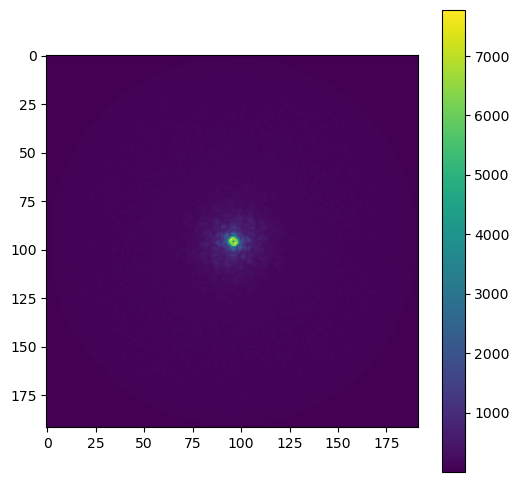

In [58]:
# mip_z(np.fft.fftshift(np.abs(v_rec)))
plt.figure(figsize=(6,6))
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_np)), axis=2))

plt.colorbar()

In [59]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_np.npy", iterates_np)
    jnp.save(f"{iterates_file_root}/iterates_np_loss.npy", loss_np)
    jnp.save(f"{iterates_file_root}/step_sizes_np.npy", step_sizes_np)

In [52]:
load_iterates = True

if load_iterates:
    iterates_np = np.load(f"{iterates_file_root}/iterates_np.npy")
    loss_np = jnp.load(f"{iterates_file_root}/iterates_np_loss.npy")
    step_sizes_np = jnp.load(f"{iterates_file_root}/step_sizes_np.npy")

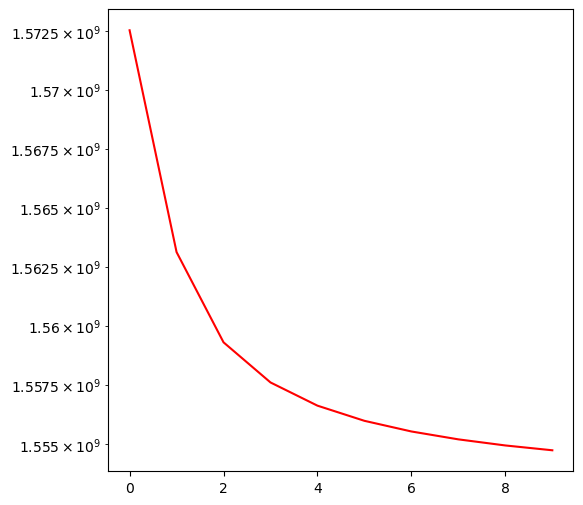

In [20]:
plt.semilogy(loss_np, "r")

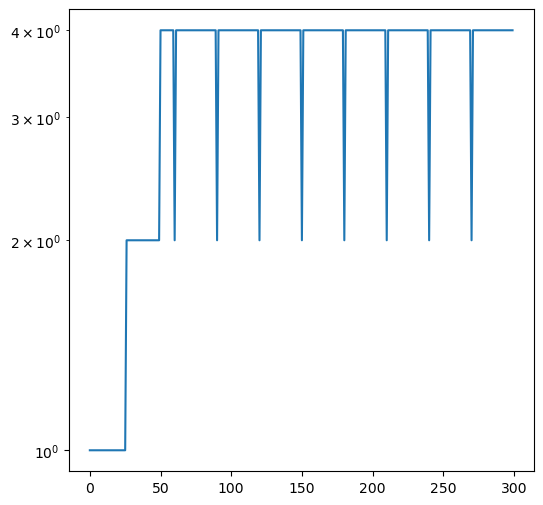

In [21]:
plt.semilogy(step_sizes_np)

### 2a. SGD: precomputed preconditioner (no thresholding) + adaptive line search

No thresholding of the preconditioner, so we use `D0`.

In [56]:
t0 = time.time()

(
    v_pp_nothresh,
    loss_pp_nothresh,
    grad_pp_nothresh,
    iterates_pp_nothresh,
    step_sizes_pp_nothresh,
) = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    D0=D0,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
)  

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 30/30 [00:24<00:00,  1.24it/s, eta=7.812e-03, grad=1.578e+01, 


  |Grad| = 2.284e+01
  Loss = 1.56576815e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 2/10 

100%|█| 30/30 [00:24<00:00,  1.25it/s, eta=7.812e-03, grad=1.055e+01, 


  |Grad| = 1.432e+01
  Loss = 1.55846935e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 3/10 

100%|█| 30/30 [00:24<00:00,  1.24it/s, eta=7.812e-03, grad=8.334e+00, 


  |Grad| = 1.026e+01
  Loss = 1.55603957e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 4/10 

100%|█| 30/30 [00:24<00:00,  1.24it/s, eta=7.812e-03, grad=5.828e+00, 


  |Grad| = 8.018e+00
  Loss = 1.55506315e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 5/10 

100%|█| 30/30 [00:24<00:00,  1.25it/s, eta=7.812e-03, grad=6.508e+00, 


  |Grad| = 6.915e+00
  Loss = 1.55457769e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 6/10 

100%|█| 30/30 [00:23<00:00,  1.25it/s, eta=7.812e-03, grad=6.806e+00, 


  |Grad| = 6.733e+00
  Loss = 1.55428765e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 7/10 

100%|█| 30/30 [00:23<00:00,  1.25it/s, eta=7.812e-03, grad=6.872e+00, 


  |Grad| = 6.629e+00
  Loss = 1.55409255e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 8/10 

100%|█| 30/30 [00:24<00:00,  1.25it/s, eta=7.812e-03, grad=7.217e+00, 


  |Grad| = 6.565e+00
  Loss = 1.55395117e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 9/10 

100%|█| 30/30 [00:24<00:00,  1.25it/s, eta=7.812e-03, grad=6.890e+00, 


  |Grad| = 6.564e+00
  Loss = 1.55384446e+09
  eta = 0.0078125
  alpha = 1e-10
Epoch 10/10 

100%|█| 30/30 [00:24<00:00,  1.24it/s, eta=7.812e-03, grad=6.807e+00, 


  |Grad| = 6.635e+00
  Loss = 1.55376179e+09
  eta = 0.0078125
  alpha = 1e-10
Total time:  272.21 seconds


In [61]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_pp_nothresh.npy", iterates_pp_nothresh)
    jnp.save(f"{iterates_file_root}/iterates_pp_nothresh_loss.npy", loss_pp_nothresh)
    jnp.save(f"{iterates_file_root}/step_sizes_pp_nothresh.npy", step_sizes_pp_nothresh)

In [69]:
load_iterates = True

if load_iterates:
    iterates_pp_nothresh = np.load(f"{iterates_file_root}/iterates_pp_nothresh.npy")
    loss_pp_nothresh = jnp.load(f"{iterates_file_root}/iterates_pp_nothresh_loss.npy")
    step_sizes_pp_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_pp_nothresh.npy")

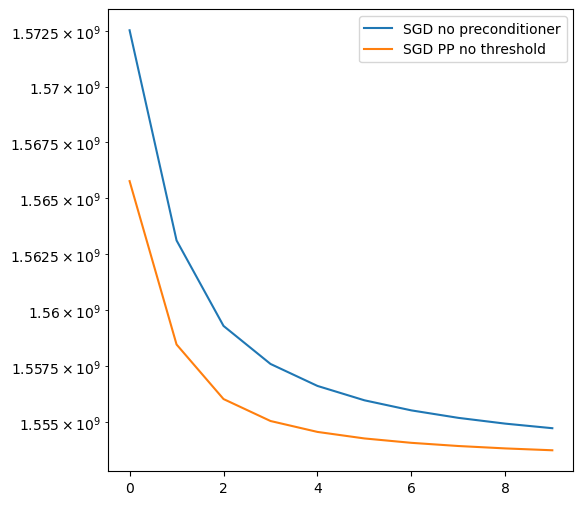

In [70]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp_nothresh, label='SGD PP no threshold')
plt.legend()

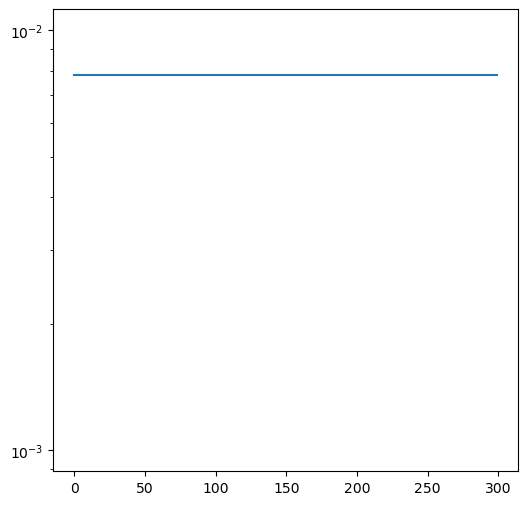

In [71]:
plt.semilogy(step_sizes_pp_nothresh)

### 2b. SGD: precomputed preconditioner (with thresholding) + adaptive line search

Here we use the thresholded precomputed preconditioner `D0hat`.

In [73]:
t0 = time.time()

(
    v_pp,
    loss_pp,
    grad_pp,
    iterates_pp,
    step_sizes_pp,
) = sgd(
    key_alg,
    grad_func,
    loss_func,
    N,
    x0,
    eta_sgd,
    N_epochs,
    batch_size,
    D0=D0hat,
    adaptive_step_size=True,
    c=c,
    verbose=True,
    iter_display=iter_display,
    alpha=alpha,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10 

100%|█| 30/30 [00:23<00:00,  1.27it/s, eta=7.812e-03, grad=1.578e+01, 


  |Grad| = 2.284e+01
  Loss = 1.56576815e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 2/10 

100%|█| 30/30 [00:23<00:00,  1.28it/s, eta=7.812e-03, grad=1.055e+01, 


  |Grad| = 1.432e+01
  Loss = 1.55846935e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 3/10 

100%|█| 30/30 [00:23<00:00,  1.28it/s, eta=7.812e-03, grad=8.334e+00, 


  |Grad| = 1.026e+01
  Loss = 1.55603957e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 4/10 

100%|█| 30/30 [00:24<00:00,  1.23it/s, eta=7.812e-03, grad=5.828e+00, 


  |Grad| = 8.018e+00
  Loss = 1.55506315e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 5/10 

100%|█| 30/30 [00:24<00:00,  1.22it/s, eta=7.812e-03, grad=6.508e+00, 


  |Grad| = 6.915e+00
  Loss = 1.55457769e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 6/10 

100%|█| 30/30 [00:24<00:00,  1.22it/s, eta=7.812e-03, grad=6.806e+00, 


  |Grad| = 6.733e+00
  Loss = 1.55428765e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 7/10 

100%|█| 30/30 [00:24<00:00,  1.23it/s, eta=7.812e-03, grad=6.872e+00, 


  |Grad| = 6.629e+00
  Loss = 1.55409255e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 8/10 

100%|█| 30/30 [00:24<00:00,  1.23it/s, eta=7.812e-03, grad=7.217e+00, 


  |Grad| = 6.565e+00
  Loss = 1.55395117e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 9/10 

100%|█| 30/30 [00:24<00:00,  1.24it/s, eta=7.812e-03, grad=6.890e+00, 


  |Grad| = 6.564e+00
  Loss = 1.55384446e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Epoch 10/10 

100%|█| 30/30 [00:24<00:00,  1.23it/s, eta=7.812e-03, grad=6.807e+00, 


  |Grad| = 6.635e+00
  Loss = 1.55376179e+09
  eta = 0.0078125
  alpha = 5.213981813631434e-06
Total time:  272.29 seconds


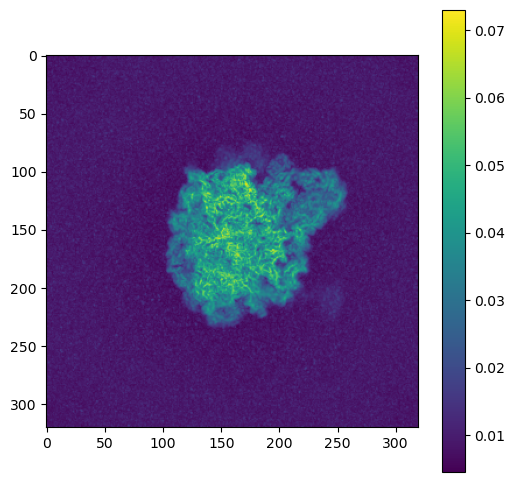

In [74]:
v_pp_l, _ = rescale_larger_grid(v_pp, x_grid, nx0)
vr_pp = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_pp_l)))

mip_z(vr_pp)
plt.colorbar()

In [75]:
with mrcfile.new(f"{out_dir}/v_pp_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_pp.astype(np.float32))

vr_pp_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_pp)))

with mrcfile.new(f"{out_dir}/v_pp_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_pp_nx.astype(np.float32))

In [22]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_pp_nx.mrc") as mrc:
        vr_pp_loaded = mrc.data

    v_pp_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_pp_loaded)))

In [78]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_pp.npy", iterates_pp)
    jnp.save(f"{iterates_file_root}/iterates_pp_loss.npy", loss_pp)
    jnp.save(f"{iterates_file_root}/step_sizes_pp.npy", step_sizes_pp)

In [72]:
load_iterates = True

if load_iterates:
    iterates_pp = np.load(f"{iterates_file_root}/iterates_pp.npy")
    loss_pp = jnp.load(f"{iterates_file_root}/iterates_pp_loss.npy")
    step_sizes_pp = jnp.load(f"{iterates_file_root}/step_sizes_pp.npy")

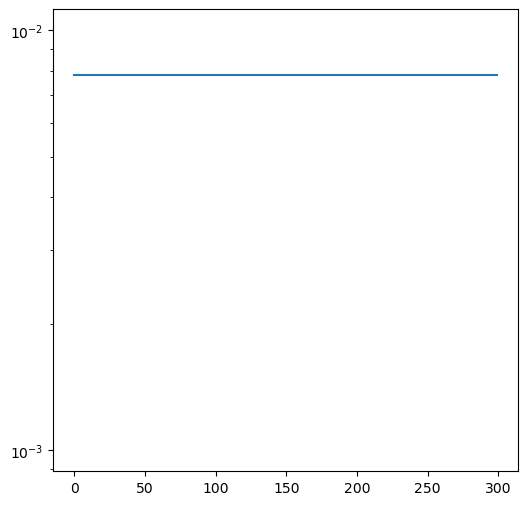

In [73]:
plt.semilogy(step_sizes_pp)

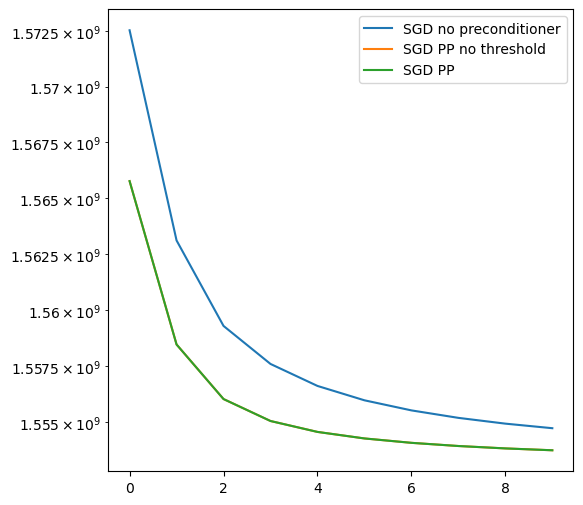

In [74]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp_nothresh, label='SGD PP no threshold')
plt.semilogy(loss_pp, label='SGD PP')

plt.legend()

### 3a. SGD: estimated preconditioner: `Algorithm 1`

This is the proposed algorithm, which starts with the identity preconditioner and approximates the Hessian diagonal using Hutchinson's estimator in minibatches.

In [83]:
t0 = time.time()

v_ep, loss_ep, iterates_ep, step_sizes_ep = precon_sgd(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha,
    N_epochs,
    batch_size=batch_size,
    N=N,
    adaptive_step_size=True,
    c=c,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10


100%|██| 30/30 [00:28<00:00,  1.06it/s, eta=9.055e-03, loss=1.569e+09]


  Loss =  1.56843042e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 2/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.561e+09]


  Loss =  1.55949748e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 3/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.556e+09]


  Loss =  1.55644876e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 4/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.556e+09]


  Loss =  1.55526065e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 5/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.553e+09]


  Loss =  1.55469597e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 6/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.552e+09]


  Loss =  1.55436996e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 7/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.556e+09]


  Loss =  1.55415345e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 8/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.554e+09]


  Loss =  1.55399951e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 9/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.553e+09]


  Loss =  1.55388530e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Epoch 10/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.552e+09]


  Loss =  1.55379854e+09
  eta = 0.009055187751761229
  alpha= 5.213981813631434e-06
Total time:  297.05 seconds


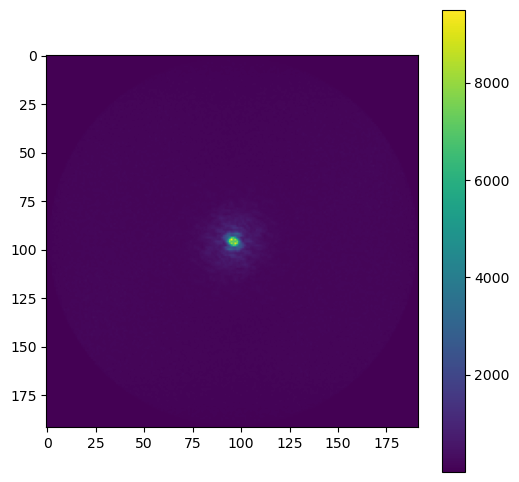

In [84]:
plt.imshow(jnp.max(np.fft.fftshift(np.abs(v_ep)), axis=1))
plt.colorbar()

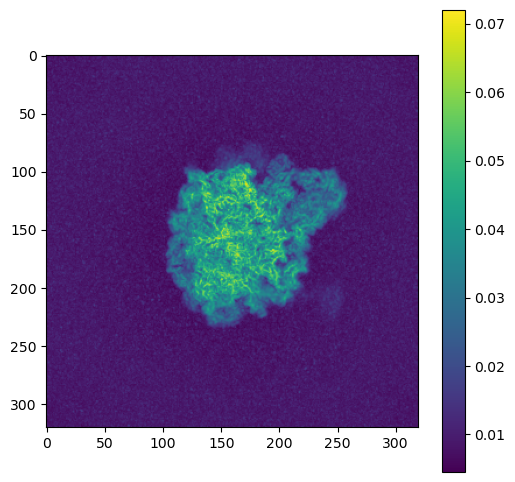

In [85]:
v_ep_l, _ = rescale_larger_grid(v_ep, x_grid, nx0)
vr_ep = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_ep_l)))

mip_z(vr_ep)
plt.colorbar()

In [86]:
with mrcfile.new(f"{out_dir}/v_ep_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_ep.astype(np.float32))

vr_ep_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_ep)))

with mrcfile.new(f"{out_dir}/v_ep_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_ep_nx.astype(np.float32))

In [27]:
# or load
load_rec = True

if load_rec:
    with mrcfile.open(f"{out_dir}/v_ep_nx.mrc") as mrc:
        vr_ep_loaded = mrc.data

    v_ep_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_ep_loaded)))

In [88]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_ep.npy", iterates_ep)
    jnp.save(f"{iterates_file_root}/iterates_ep_loss.npy", loss_ep)
    jnp.save(f"{iterates_file_root}/step_sizes_ep.npy", step_sizes_ep)

In [53]:
load_iterates = True

if load_iterates:
    iterates_ep = np.load(f"{iterates_file_root}/iterates_ep.npy")
    loss_ep = jnp.load(f"{iterates_file_root}/iterates_ep_loss.npy")
    step_sizes_ep = jnp.load(f"{iterates_file_root}/step_sizes_ep.npy")

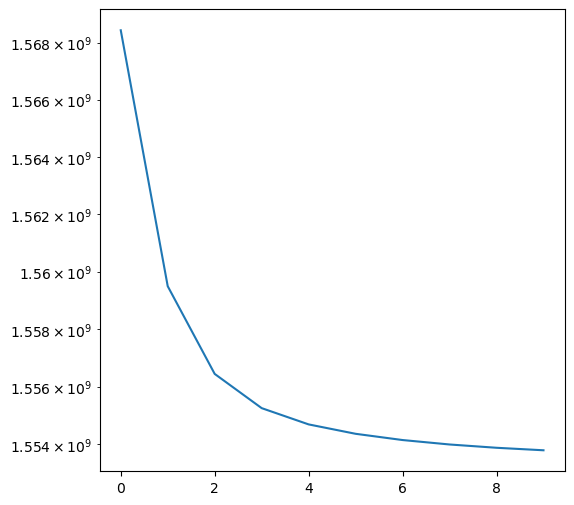

In [29]:
plt.semilogy(loss_ep)

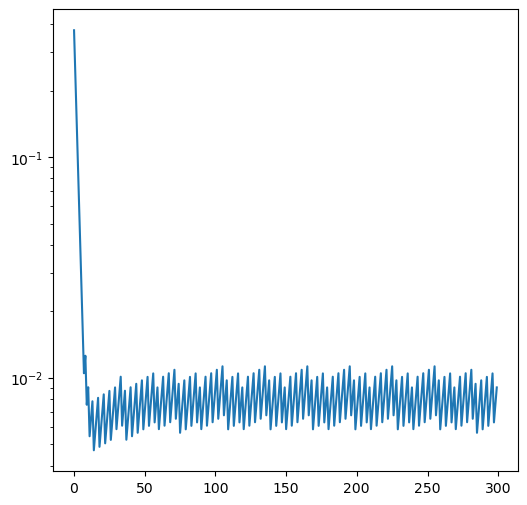

In [30]:
plt.semilogy(step_sizes_ep)

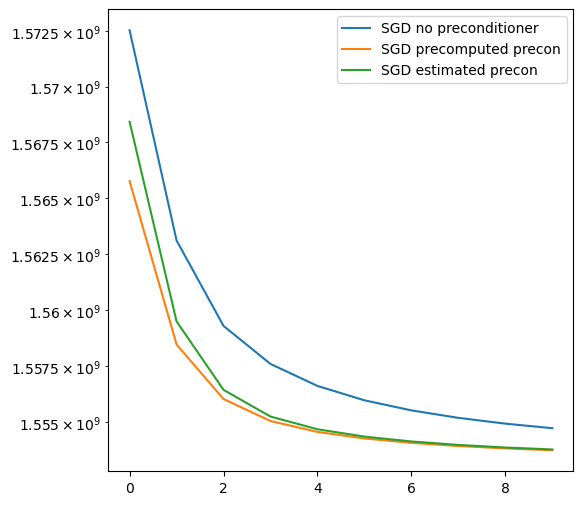

In [31]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.legend()

### 3b. SGD: estimated preconditioner, no thresholding

In [32]:
t0 = time.time()
alpha_nothresh = 1e-14
v_ep_nothresh, loss_ep_nothresh, iterates_ep_nothresh, step_sizes_ep_nothresh = precon_sgd(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha_nothresh,
    N_epochs,
    batch_size=batch_size,
    N=N,
    adaptive_step_size=True,
    c=c,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/10


100%|██| 30/30 [00:40<00:00,  1.35s/it, eta=7.244e-02, loss=1.574e+09]


  Loss =  1.57207012e+09
  eta = 0.07244150201408983
  alpha= 1e-14
Epoch 2/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=1.811e-02, loss=1.563e+09]


  Loss =  1.56166543e+09
  eta = 0.018110375503522458
  alpha= 1e-14
Epoch 3/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.557e+09]


  Loss =  1.55740897e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 4/10


100%|██| 30/30 [00:26<00:00,  1.12it/s, eta=9.055e-03, loss=1.557e+09]


  Loss =  1.55576115e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 5/10


100%|██| 30/30 [00:26<00:00,  1.12it/s, eta=9.055e-03, loss=1.554e+09]


  Loss =  1.55500704e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 6/10


100%|██| 30/30 [00:26<00:00,  1.12it/s, eta=9.055e-03, loss=1.552e+09]


  Loss =  1.55458206e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 7/10


100%|██| 30/30 [00:26<00:00,  1.13it/s, eta=9.055e-03, loss=1.556e+09]


  Loss =  1.55430605e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 8/10


100%|██| 30/30 [00:26<00:00,  1.14it/s, eta=9.055e-03, loss=1.554e+09]


  Loss =  1.55411281e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 9/10


100%|██| 30/30 [00:26<00:00,  1.15it/s, eta=9.055e-03, loss=1.553e+09]


  Loss =  1.55397137e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Epoch 10/10


100%|██| 30/30 [00:26<00:00,  1.15it/s, eta=9.055e-03, loss=1.552e+09]


  Loss =  1.55386553e+09
  eta = 0.009055187751761229
  alpha= 1e-14
Total time:  310.56 seconds


In [33]:
save_iterates = True

if save_iterates:
    jnp.save(f"{iterates_file_root}/iterates_ep_nothresh.npy", iterates_ep_nothresh)
    jnp.save(f"{iterates_file_root}/iterates_ep_nothresh_loss.npy", loss_ep_nothresh)
    jnp.save(f"{iterates_file_root}/step_sizes_ep_nothresh.npy", step_sizes_ep_nothresh)

In [54]:
load_iterates = True

if load_iterates:
    iterates_ep_nothresh = np.load(f"{iterates_file_root}/iterates_ep_nothresh.npy")
    loss_ep_nothresh = jnp.load(f"{iterates_file_root}/iterates_ep_nothresh_loss.npy")
    step_sizes_ep_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_ep_nothresh.npy")

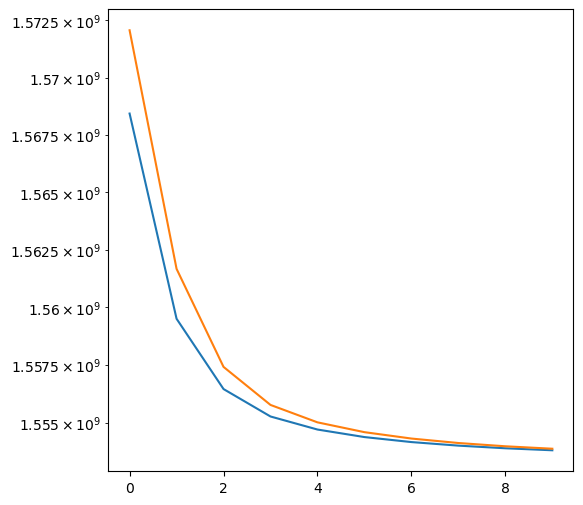

In [55]:
plt.semilogy(loss_ep)
plt.semilogy(loss_ep_nothresh)

In [36]:
np.sum(np.abs(D0) < 1e-5)/np.prod(D0.shape)

0.49266461972837094

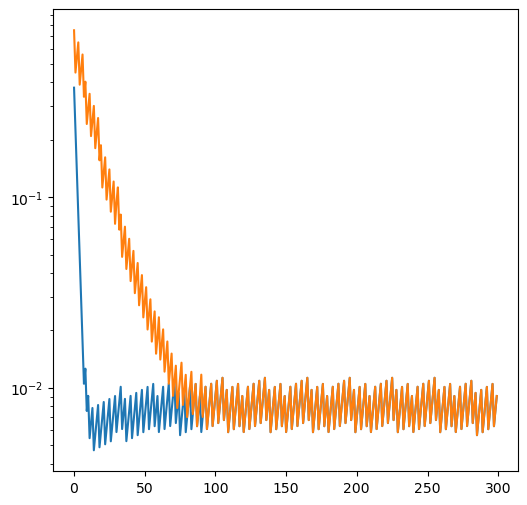

In [37]:
plt.semilogy(step_sizes_ep)
plt.semilogy(step_sizes_ep_nothresh)

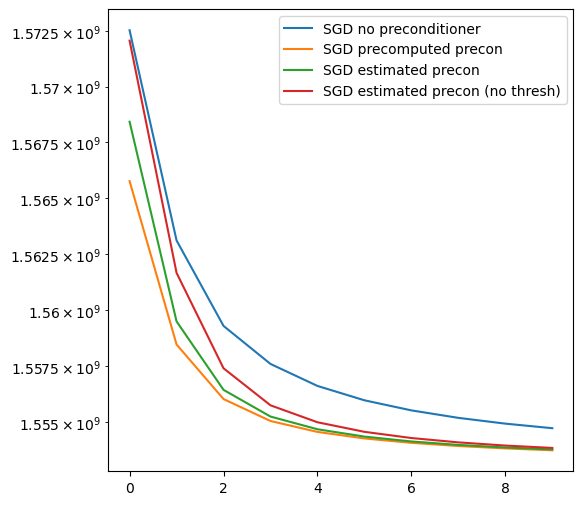

In [38]:
plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.legend()

### OASIS as in described in Jahani et al

In [ ]:
t0 = time.time()

v_oa, loss_oa = oasis_adaptive(
    key_alg,
    loss_func,
    grad_func,
    hvp_func,
    x0,
    eta_precon_sgd,
    jnp.ones(x0.shape),
    beta,
    alpha,
    N_epochs,
    batch_size=batch_size,
    N=N,
    iter_display=iter_display,
)

print(f"Total time: {time.time()-t0 : .2f} seconds")

In [ ]:
plt.legend()

plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_oa, label='OASIS')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.title("Loss")

In [ ]:
v_oal, _ = rescale_larger_grid(v_oa, x_grid, nx0)
vr_oa = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_oal)))

mip_z(vr_oa)
plt.colorbar()

### L-BFGS

In [39]:
batch_size_lbfgs = 500
N_batch = N / batch_size_lbfgs
idx_batches = np.array_split(np.arange(N), N_batch)

# We don't jit the overall loss functions here because
# compiling the unrolled iterations over all batches will
# take a long time.
# The individual loss_func and grad_func are jit-ed.
def loss_and_grad_full_func_lbfgs(x):
    t0 = time.time()
    print("loss_and_grad_full_func_lbfgs called ", end="")
    loss = 0
    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        grad += grad_func(x, idx)
        n += 1

    loss = loss / n
    grad = grad / n

    # loss_full = jnp.mean(jnp.array(loss_b), axis = 0)
    # grad_full = jnp.mean(jnp.array(grad_b), axis = 0)

    tt = time.time() - t0
    print(f"{tt} seconds")
    return loss, jnp.conj(grad)

def loss_full_func_lbfgs(x):
    t0 = time.time()
    print("loss_full_func_lbfgs called ", end="")
    loss = 0
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        n += 1

    loss = loss / n
    
    tt = time.time() - t0
    print(f"{tt} seconds")
    return loss

In [40]:
t0 = time.time()
r1, r2 = loss_and_grad_full_func_lbfgs(x0)
r1 = loss_full_func_lbfgs(x0)

t1 = time.time() - t0

print(t1)

loss_and_grad_full_func_lbfgs called 18.684876680374146 seconds
loss_full_func_lbfgs called 2.927457571029663 seconds
21.61293339729309


In [95]:
# [x.delete() for x in jax.devices()[0].client.live_buffers()]

In [96]:
# Both zoom (default) and backtracking line searches hang, so we'll use neither with a learning rate of 0.5.
solver = optax.lbfgs(learning_rate=0.5, linesearch=None)
opt_state = solver.init(x0)

In [97]:
losses_lbfgs = []
v_lbfgs = x0

In [98]:
N_iters = 750
for i in range(N_iters):
    print(f'Iter {i}')
    value, grad = loss_and_grad_full_func_lbfgs(v_lbfgs)
    losses_lbfgs.append(value)
    updates, opt_state = solver.update(
        grad, opt_state, v_lbfgs, value=value, grad=grad, value_fn=loss_full_func_lbfgs
    )
    v_lbfgs = optax.apply_updates(v_lbfgs, updates)
    print('Objective function: ', value)
losses_lbfgs = jnp.array(losses_lbfgs)

Iter 0
loss_and_grad_full_func_lbfgs called 9.480963230133057 seconds
Objective function:  1590689304.3471415
Iter 1
loss_and_grad_full_func_lbfgs called 9.447099208831787 seconds
Objective function:  1590189280.2184484
Iter 2
loss_and_grad_full_func_lbfgs called 9.461094856262207 seconds
Objective function:  1571440617.587146
Iter 3
loss_and_grad_full_func_lbfgs called 9.577111721038818 seconds
Objective function:  1564394599.0730448
Iter 4
loss_and_grad_full_func_lbfgs called 9.45576810836792 seconds
Objective function:  1561066984.1502485
Iter 5
loss_and_grad_full_func_lbfgs called 9.410261869430542 seconds
Objective function:  1558965883.7794983
Iter 6
loss_and_grad_full_func_lbfgs called 9.420559167861938 seconds
Objective function:  1557464938.9005353
Iter 7
loss_and_grad_full_func_lbfgs called 9.458352088928223 seconds
Objective function:  1556646018.2320638
Iter 8
loss_and_grad_full_func_lbfgs called 9.460200071334839 seconds
Objective function:  1555877847.5973134
Iter 9
loss_

KeyboardInterrupt: 

1553355562.3120234


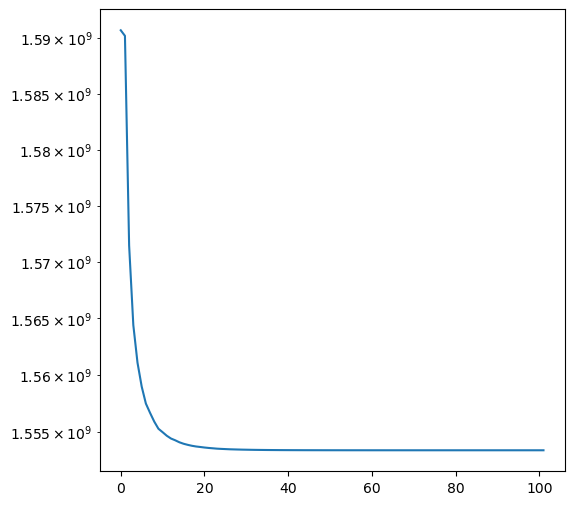

In [99]:
plt.semilogy(losses_lbfgs)
print(losses_lbfgs[-1])

In [100]:
loss_lbfgs = loss_full_func_lbfgs(v_lbfgs)
print(loss_lbfgs)

loss_full_func_lbfgs called 2.949950695037842 seconds
1553355561.3713472


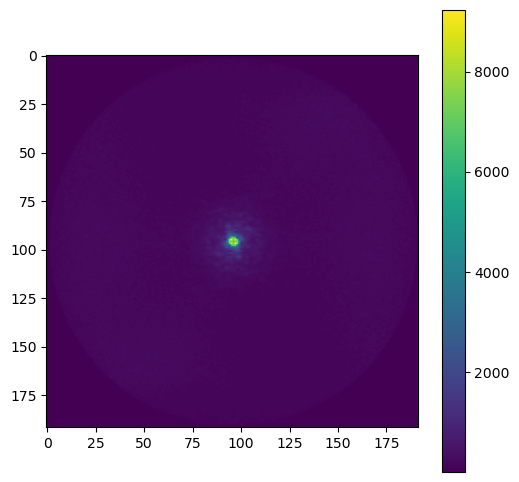

In [101]:
mip_x(np.fft.fftshift(np.abs(v_lbfgs)))
plt.colorbar()

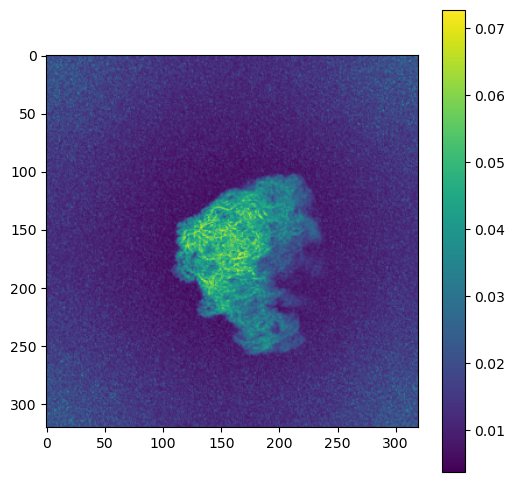

In [102]:
v_lbfgs_l, _ = rescale_larger_grid(v_lbfgs, x_grid, nx0)
vr_lbfgs = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs_l)))

mip_x(vr_lbfgs)
plt.colorbar()

In [105]:
nnstring = ""


In [106]:
# Save two: at the original nx0 (=320) and at the actual computed nx so no accuracy is lost
with mrcfile.new(
    f"{out_dir}/v_rec_lbfgs_{nnstring}{N_iters}_nx0.mrc", overwrite=True
) as mrc:
    mrc.set_data(vr_lbfgs.astype(np.float32))

vr_lbfgs_nx = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs)))
# vr_lbfgs_nx = jnp.fft.ifftn(v_lbfgs)

with mrcfile.new(f"{out_dir}/v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_lbfgs_nx.astype(np.float32))

In [107]:
v_lbfgs_nx = jnp.fft.fftn(jnp.fft.ifftshift(vr_lbfgs_nx))

In [42]:
load_v_lbfgs = True

if load_v_lbfgs:
    # Load
    # nnstring = "nn_"
    nnstring = ""
    N_iters = 750
    
    with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
        vr_lbfgs_loaded = mrc.data
    
    v_lbfgs_loaded = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs_loaded)))
    
    vr_lbfgs = vr_lbfgs_loaded
    v_lbfgs = v_lbfgs_loaded

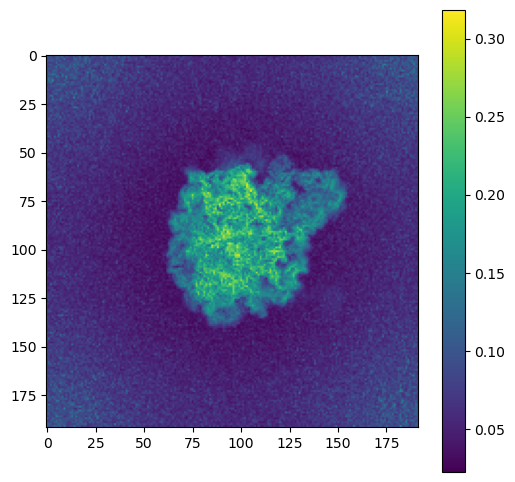

In [43]:
mip_z(vr_lbfgs_loaded)
plt.colorbar()

In [44]:
vrerr = jnp.abs(v_lbfgs - v_lbfgs_loaded)
print(jnp.max(vrerr) / jnp.max(jnp.abs(v_lbfgs)))
print(jnp.mean(vrerr) / jnp.max(jnp.abs(v_lbfgs)))

0.0
0.0


In [47]:
loss_lbfgs = loss_full_func_lbfgs(v_lbfgs)

print(loss_lbfgs)

loss_full_func_lbfgs called 6.413977146148682 seconds
1553355644.6529844


Text(0.5, 1.0, 'Loss')

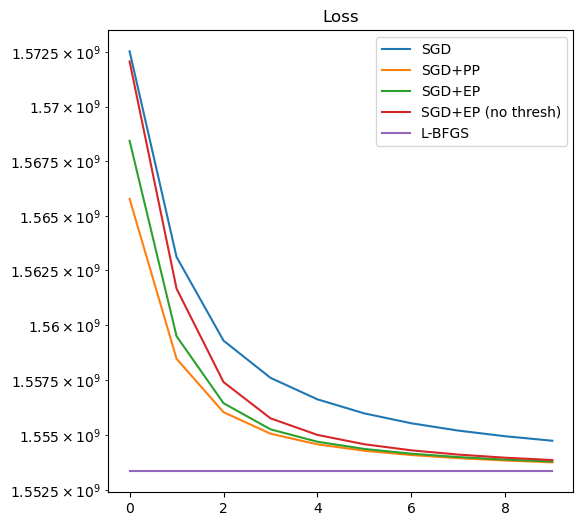

In [48]:
plt.semilogy(loss_np, label='SGD')
plt.semilogy(loss_pp, label='SGD+PP')
plt.semilogy(loss_ep, label='SGD+EP')
plt.semilogy(loss_ep_nothresh, label='SGD+EP (no thresh)')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.legend()
plt.title("Loss")

## Diagnostics


#### First: the loss and the step size

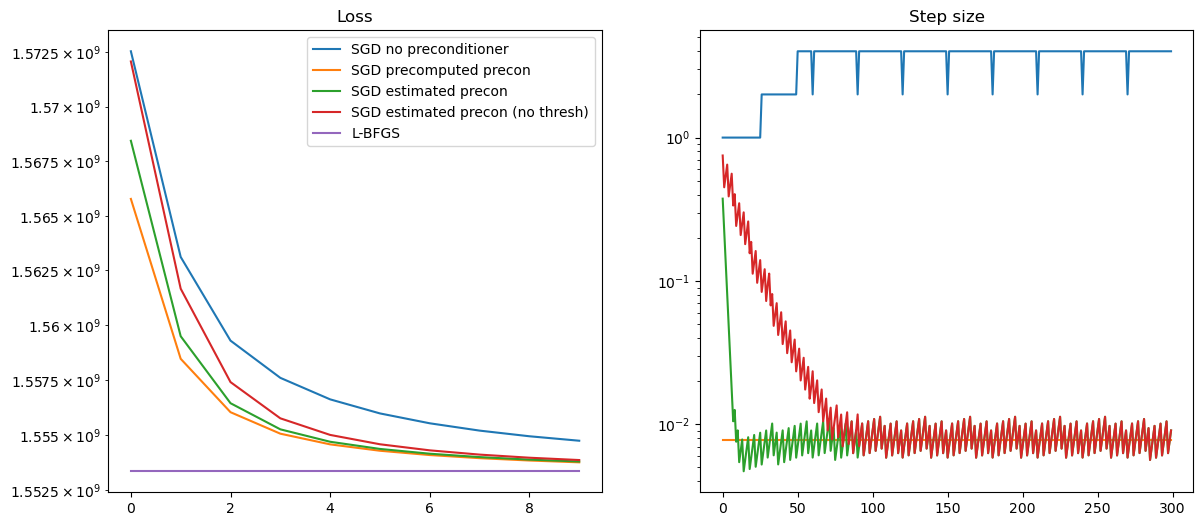

In [75]:
plt.figure(figsize=(14, 6))

plt.subplot(121)

plt.semilogy(loss_np, label='SGD no preconditioner')
plt.semilogy(loss_pp, label='SGD precomputed precon')
plt.semilogy(loss_ep, label='SGD estimated precon')
plt.semilogy(loss_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape), label='L-BFGS')
plt.legend()
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_np, label='SGD no preconditioner')
plt.semilogy(step_sizes_pp, label='SGD precomputed precon')
plt.semilogy(step_sizes_ep, label='SGD estimated precon')
plt.semilogy(step_sizes_ep_nothresh, label='SGD estimated precon (no thresh)')
plt.title("Step size")

plt.rcParams["figure.figsize"] = 6, 6

### Error and FSC (with the L-BFGS solution) in shells

In [76]:
def err_px(v1, v2):
    err = 1 / 2 * jnp.real(jnp.conj(v1 - v2) * (v1 - v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)
    
    return jnp.array([avg_err, max_err, median_err])

err_px_iterates = jax.vmap(lambda vv: err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(
    lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1
)

In [77]:
averr_np, maxerr_np, mederr_np = err_px_iterates(jnp.array(iterates_np))
averr_pp, maxerr_pp, mederr_pp = err_px_iterates(jnp.array(iterates_pp))
averr_pp_nothresh, maxerr_pp_nothresh, mederr_pp_nothresh = err_px_iterates(jnp.array(iterates_pp_nothresh))
averr_ep, maxerr_ep, mederr_ep = err_px_iterates(jnp.array(iterates_ep))
averr_ep_nothresh, maxerr_ep_nothresh, mederr_ep_nothresh = err_px_iterates(jnp.array(iterates_ep_nothresh))

print(averr_np.shape)
print(maxerr_np.shape)
print(mederr_np.shape)

(11, 55)
(11, 55)
(11, 55)


In [78]:
res, fsc_np, shell_pts = fsc_iterates(jnp.array(iterates_np))
res, fsc_pp, shell_pts = fsc_iterates(jnp.array(iterates_pp))
res, fsc_pp_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_pp_nothresh))
res, fsc_ep, shell_pts = fsc_iterates(jnp.array(iterates_ep))
res, fsc_ep_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_ep_nothresh))

print(fsc_np.shape)
print(fsc_pp.shape)
print(fsc_ep.shape)

(11, 55)
(11, 55)
(11, 55)


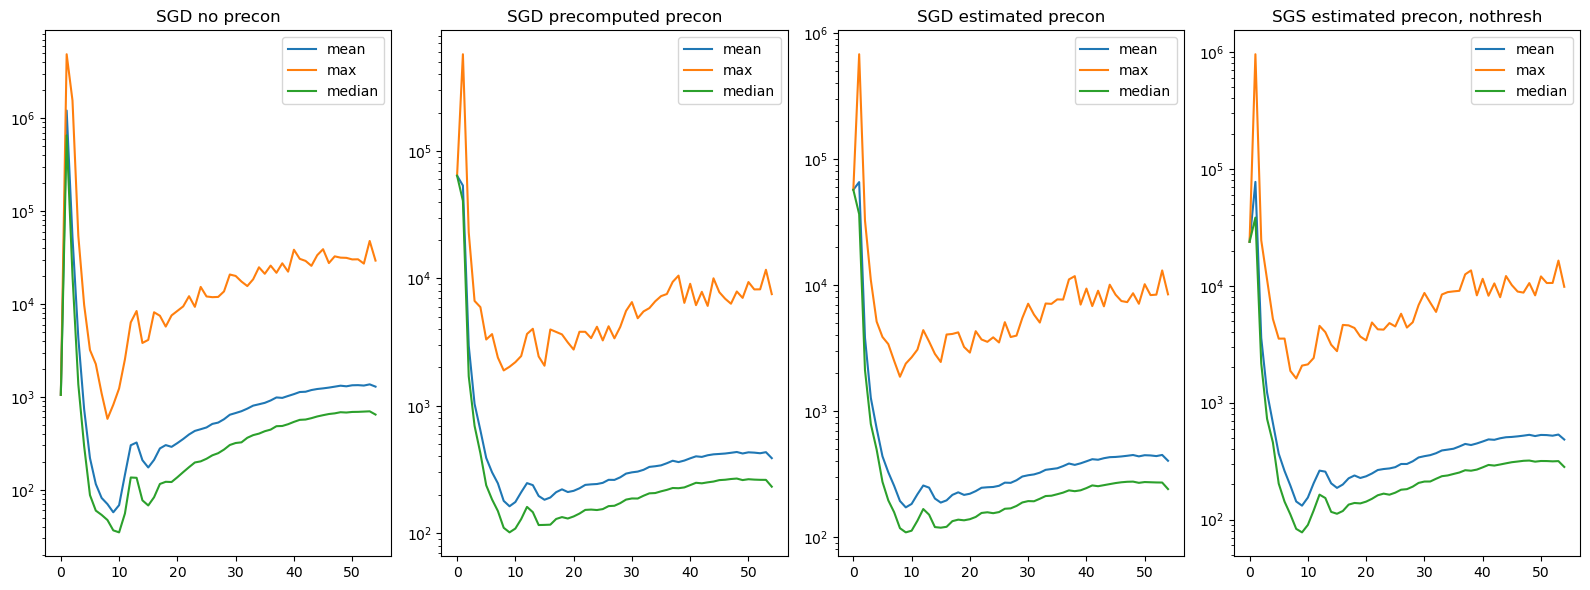

In [79]:
idx = 10

plt.figure(figsize=(16,6))
#plt.title(f'Shell {idx+1}/{averr_np.shape[-1]}\n')

#ylims = [10,10**6.6]

plt.subplot(141)
plt.semilogy((averr_np[idx]))
plt.semilogy((maxerr_np[idx]))
plt.semilogy((mederr_np[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD no precon")
#plt.ylim(ylims)

plt.subplot(142)
plt.semilogy((averr_pp[idx]))
plt.semilogy((maxerr_pp[idx]))
plt.semilogy((mederr_pp[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD precomputed precon")
#plt.ylim(ylims)

plt.subplot(143)
plt.semilogy((averr_ep[idx]))
plt.semilogy((maxerr_ep[idx]))
plt.semilogy((mederr_ep[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGD estimated precon")
plt.tight_layout()
#plt.ylim(ylims)

plt.subplot(144)
plt.semilogy((averr_ep_nothresh[idx]))
plt.semilogy((maxerr_ep_nothresh[idx]))
plt.semilogy((mederr_ep_nothresh[idx]))
plt.legend(["mean", "max", "median"])
plt.title("SGS estimated precon, nothresh")
#plt.ylim(ylims)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Error accross epochs at frequency shell 55/55')

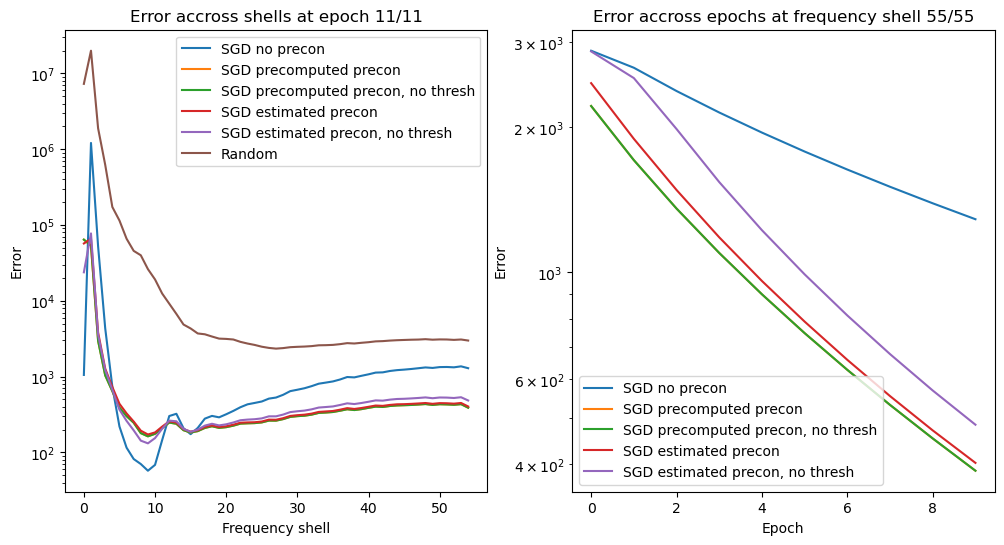

In [93]:

plt.figure(figsize=(12, 6))
#plt.title(f'Shell {idx}/{averr_np.shape[-1]}\n')

plt.subplot(121)

idx_epoch = 10
plt.semilogy(averr_np[idx_epoch])
plt.semilogy(averr_pp[idx_epoch])
plt.semilogy(averr_pp_nothresh[idx_epoch])
plt.semilogy(averr_ep[idx_epoch])
plt.semilogy(averr_ep_nothresh[idx_epoch])
plt.semilogy(averr_np[0])

plt.legend(
    [
        'SGD no precon',
        'SGD precomputed precon',
        'SGD precomputed precon, no thresh',
        'SGD estimated precon',
        'SGD estimated precon, no thresh',
        "Random",
    ]
)
plt.xlabel("Frequency shell")
plt.ylabel("Error")
plt.title(f"Error accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 54
plt.semilogy(averr_np[1:, idx_shell])
plt.semilogy(averr_pp[1:, idx_shell])
plt.semilogy(averr_pp_nothresh[1:, idx_shell])
plt.semilogy(averr_ep[1:, idx_shell])
plt.semilogy(averr_ep_nothresh[1:, idx_shell])

plt.legend(
    [
        'SGD no precon',
        'SGD precomputed precon',
        'SGD precomputed precon, no thresh',
        'SGD estimated precon',
        'SGD estimated precon, no thresh',
    ]
)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title(f"Error accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

#### The resolution in Angs
If ``res``, the radius in the Fourier domain, goes from 0 to R, where $R \approx \frac{Npixels}{2}$, 
then ``res_angs(res)``$=\frac{N0 pixels \times px0}{res}$,
where ``N0pixels``= number of pixels in the original images (here 320) 
and ``px0`` = pixel size (here 1.33 Angs), 
so ``res_angs`` goes from ``N0pixels x px0`` to ``N0pixels x px0 x 2 / Npixels``

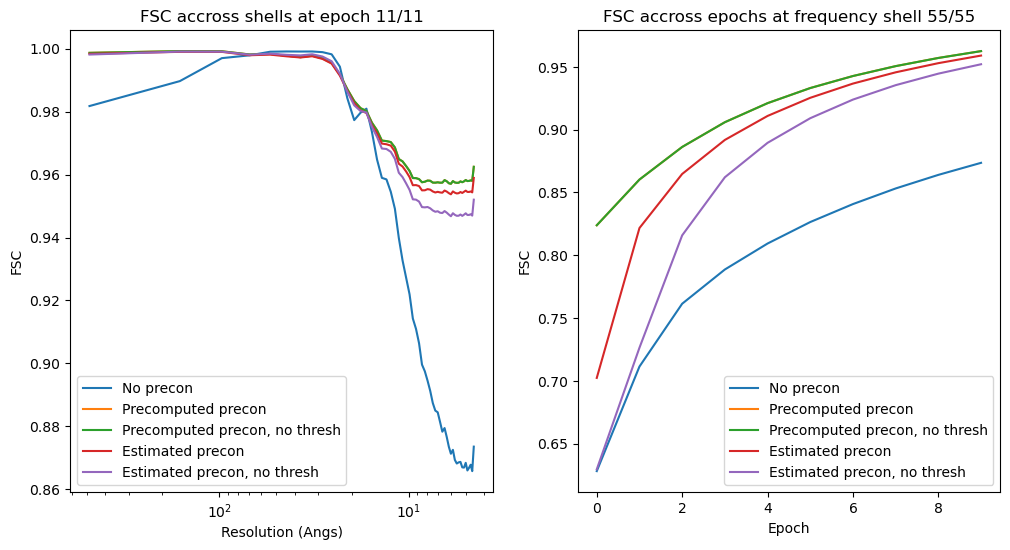

In [81]:
res_angs = nx0 * pixel_size[0] / res[0]

plt.figure(figsize=(12, 6))

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_np[idx, 1:])
plt.semilogx(res_angs[1:], fsc_pp[idx, 1:])
plt.semilogx(res_angs[1:], fsc_pp_nothresh[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep_nothresh[idx, 1:])

plt.gca().invert_xaxis()
plt.legend(
    [
        'No precon',
        'Precomputed precon',
        'Precomputed precon, no thresh',
        'Estimated precon',
        'Estimated precon, no thresh',
    ]
)
plt.xlabel("Resolution (Angs)")
plt.ylabel("FSC")
plt.title(f"FSC accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 54
plt.plot(fsc_np[1:, idx_shell])
plt.plot(fsc_pp[1:, idx_shell])
plt.plot(fsc_pp_nothresh[1:, idx_shell])
plt.plot(fsc_ep[1:, idx_shell])
plt.plot(fsc_ep_nothresh[1:, idx_shell])

plt.legend(
    [
        'No precon',
        'Precomputed precon',
        'Precomputed precon, no thresh',
        'Estimated precon',
        'Estimated precon, no thresh',
    ]
)
plt.xlabel("Epoch")
plt.ylabel("FSC")
plt.title(f"FSC accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

### FSC heatmap for Fourier shell vs epoch

<Figure size 1800x600 with 0 Axes>

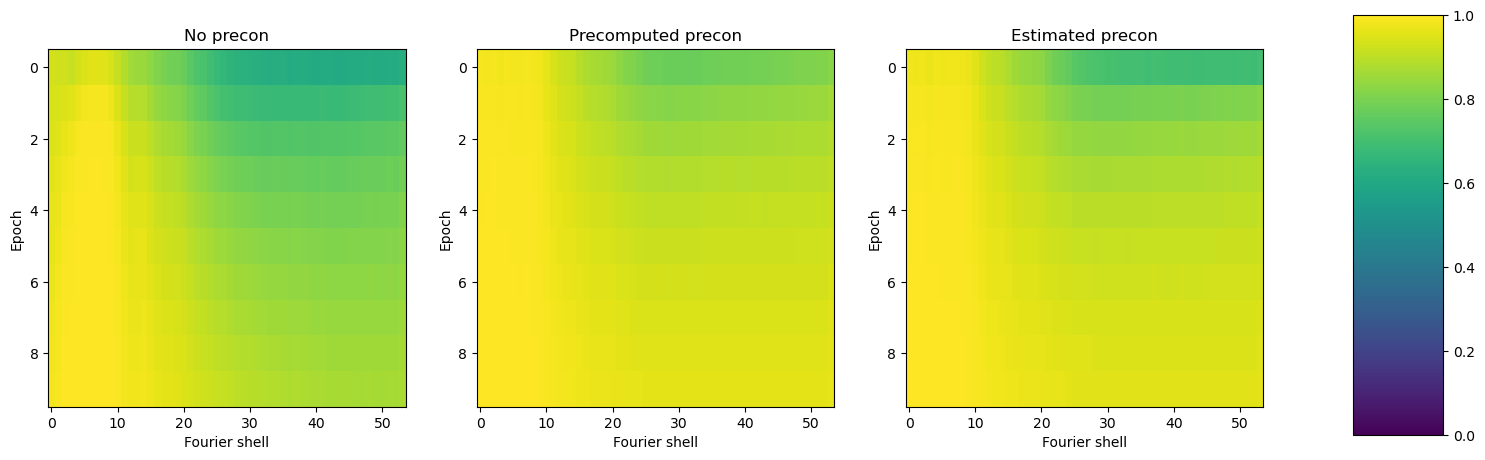

In [84]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)


plt.figure(figsize=(18, 6))

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_np[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("No precon")

ax = fig.add_subplot(132)
ax.imshow(fsc_pp[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("Precomputed precon")

ax = fig.add_subplot(133)
im = ax.imshow(fsc_ep[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("Estimated precon")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

#### Also look at the preconditioner

In [83]:
_, precon_radial_mean, _, precon_radial_max, precon_radial_median = average_shells(
    (1 / D0hat), x_grid
)
_, D0_radial_mean, _, D0_radial_max, D0_radial_median = average_shells(D0hat, x_grid)

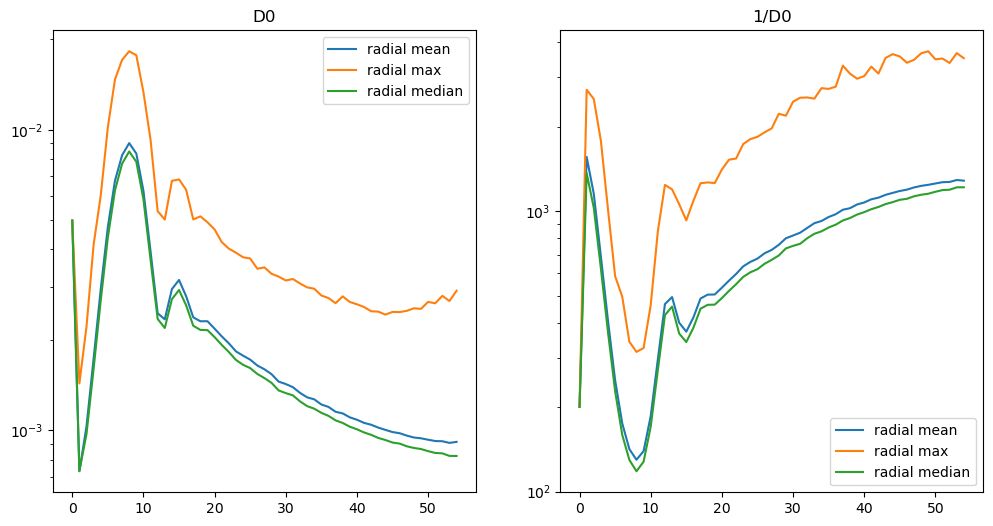

In [85]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("D0")

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("1/D0")

plt.rcParams["figure.figsize"] = 6, 6

### The variance of the gradients

In [86]:
# [x.delete() for x in jax.devices()[0].client.live_buffers()]

In [87]:
out_dir_measures = f'{out_dir}/saved_measures/'

In [88]:
key = random.PRNGKey(45)
vol = iterates_np[5]

In [89]:
def loss_full_func(x, idx_arg, batch_size=20):
    idx_batches = np.array_split(idx_arg, batch_size)

    loss = 0
    n = 0
    for idx in idx_batches:
        loss += loss_func(x, idx)
        n += 1
    loss = loss / n
    return loss


def grad_full_func(x, idx_arg, batch_size=20):
    idx_batches = np.array_split(idx_arg, batch_size)

    grad = np.zeros(x0.shape)
    n = 0
    for idx in idx_batches:
        grad += grad_func(x, idx)
        n += 1
    grad = grad / n
    return grad
    

def compute_grad_variance(key, v, batch_size, P=None):
    idxs_rand = random.permutation(key, jnp.arange(N))
    N_batch = int(N / batch_size)

    if P is None:
        P = jnp.ones(v.shape)

    # Doing this on GPU with JAX takes _extremely_ long to compile.
    # DO NOT ATTEMPT !!!
    idx_batches = np.array(np.array_split(np.array(idxs_rand), N_batch))

    grads = []
    for idx in tqdm(idx_batches):
        grads.append(P * grad_func(v, idx))
    grads = np.array(grads)

    mean_grad = np.mean(grads, axis=0)
    var_grad = np.var(grads, axis=0)

    return mean_grad, var_grad

In [ ]:
grad_full = grad_full_func(vol, np.arange(N), batch_size=1000)
mean_grad_1000, var_grad_1000 = compute_grad_variance(key, vol, 50)

In [ ]:
assert jnp.max(jnp.abs(grad_full - mean_grad_1000)) < 1e-13

In [ ]:
jnp.save(f"{out_dir_measures}/grad_full.npy", grad_full)
jnp.save(f"{out_dir_measures}/var_grad_1000.npy", var_grad_1000)

In [ ]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid)  # The median computation doesn't like complex numbers
_, av_var_grad_1000, _, _, _ = average_shells(var_grad_1000, x_grid)

In [ ]:
plt.semilogy(jnp.abs(avgrad_full[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000[:45]))

plt.title("Variance of the non-preconditioned gradients")
plt.legend(["mean grad", "var grad 1000"])

#### Without thresholding

In [ ]:
grad_full_p_d0 = 1 / D0 * grad_full
mean_grad_1000_p_d0, var_grad_1000_p_d0 = compute_grad_variance(key, vol, 50,  1/D0)

In [ ]:
assert jnp.max(jnp.abs(mean_grad_1000_p_d0 - grad_full_p_d0)) < 1e-10

In [ ]:
jnp.save(f"{out_dir_measures}/grad_full_p_d0.npy", grad_full_p_d0)
jnp.save(f"{out_dir_measures}/var_grad_1000_p_d0.npy", var_grad_1000_p_d0)

In [ ]:
_, avgrad_full_p_d0, _, _, _ = average_shells(
    jnp.abs(grad_full_p_d0), x_grid
)  # The median computation doesn't like complex numbers
_, av_var_grad_1000_p_d0, _, _, _ = average_shells(var_grad_1000_p_d0, x_grid)

In [ ]:
plt.semilogy(jnp.abs(avgrad_full_p_d0[:]))
plt.semilogy(jnp.abs(av_var_grad_1000_p_d0[:]))

plt.title("Variance of the preconditioned gradients, no thresholding")
plt.legend(["mean grad", "var grad 1000"])

#### With thresholding

In [ ]:
grad_full_p = 1 / D0hat * grad_full

mean_grad_1000_p, var_grad_1000_p = compute_grad_variance(key, vol, 50, 1 / D0hat)

In [ ]:
assert jnp.max(jnp.abs(mean_grad_1000_p - grad_full_p)) < 1e-10

In [ ]:
jnp.save(f"{out_dir_measures}/grad_full_p_dhat.npy", grad_full_p)
jnp.save(f"{out_dir_measures}/var_grad_1000_p_dhat.npy", var_grad_1000_p)

In [ ]:
_, avgrad_full_p, _, _, _ = average_shells(
    jnp.abs(grad_full_p), x_grid
)  # The median computation doesn't like complex numbers
_, av_var_grad_1000_p, _, _, _ = average_shells(var_grad_1000_p, x_grid)

In [ ]:
plt.semilogy(jnp.abs(avgrad_full_p[:45]))
plt.semilogy(jnp.abs(av_var_grad_1000_p[:45]))

plt.title("Variance of the preconditioned gradients, with thresholding")
plt.legend(["mean grad", "var grad 1000"])